In [ ]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00


## Preparing the dataset

In [ ]:
from datasets import load_dataset

In [ ]:
raw_datasets = load_dataset("conll2003")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [5]:
raw_datasets["train"][0]["tokens"]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [6]:
raw_datasets["train"][0]["ner_tags"]

[3, 0, 7, 0, 0, 0, 7, 0, 0]

In [7]:
ner_feature = raw_datasets["train"].features["ner_tags"]
ner_feature

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

In [9]:
label_names = ner_feature.feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [10]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [11]:
inputs = tokenizer(raw_datasets["train"][0]["tokens"], is_split_into_words=True)
inputs.tokens()

['[CLS]',
 'EU',
 'rejects',
 'German',
 'call',
 'to',
 'boycott',
 'British',
 'la',
 '##mb',
 '.',
 '[SEP]']

In [19]:
inputs.word_ids()

[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]

In [20]:
raw_datasets["train"][0]["ner_tags"]

[3, 0, 7, 0, 0, 0, 7, 0, 0]

In [14]:
for i, label in enumerate(label_names):
  print(i, label)

0 O
1 B-PER
2 I-PER
3 B-ORG
4 I-ORG
5 B-LOC
6 I-LOC
7 B-MISC
8 I-MISC


In [15]:
[label_names[i] for i in raw_datasets["train"][0]["ner_tags"]]

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

fix length

In [27]:
def align_labels_with_tokens(labels, word_ids):
  # labels = [3, 0, 7, 0, 0, 0, 7, 0, 0]
  # word_ids = [None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]

  new_labels = []
  prev_word_id = None

  for word_id in word_ids:
    if word_id is None:
      new_labels.append(-100)
    else:
      label = labels[word_id]
      if prev_word_id == word_id:
        # continuation of previous word
        if label % 2 == 1:
          label += 1
      new_labels.append(label)
    prev_word_id = word_id

  return new_labels

In [28]:
labels = raw_datasets["train"][0]["ner_tags"]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

[3, 0, 7, 0, 0, 0, 7, 0, 0]
[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]


In [29]:
def tokenize_and_align_labels(examples):
  # tokenizer automatically handles multiple inputs
  tokenized_inputs = tokenizer(
      examples["tokens"], truncation=True, is_split_into_words=True
  )
  # to compute labels, we need to iterate over list of old labels
  old_labels = examples["ner_tags"]
  new_labels = []
  for i, labels in enumerate(old_labels):
    word_ids = tokenized_inputs.word_ids(i)
    new_labels.append(align_labels_with_tokens(labels, word_ids))

  tokenized_inputs["labels"] = new_labels
  return tokenized_inputs

In [31]:
test_examples = raw_datasets["train"][:3]
test_examples

{'id': ['0', '1', '2'],
 'tokens': [['EU',
   'rejects',
   'German',
   'call',
   'to',
   'boycott',
   'British',
   'lamb',
   '.'],
  ['Peter', 'Blackburn'],
  ['BRUSSELS', '1996-08-22']],
 'pos_tags': [[22, 42, 16, 21, 35, 37, 16, 21, 7], [22, 22], [22, 11]],
 'chunk_tags': [[11, 21, 11, 12, 21, 22, 11, 12, 0], [11, 12], [11, 12]],
 'ner_tags': [[3, 0, 7, 0, 0, 0, 7, 0, 0], [1, 2], [5, 0]]}

In [32]:
tokenize_and_align_labels(test_examples)

{'input_ids': [[101, 7270, 22961, 1528, 1840, 1106, 21423, 1418, 2495, 12913, 119, 102], [101, 1943, 14428, 102], [101, 26660, 13329, 12649, 15928, 1820, 118, 4775, 118, 1659, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100], [-100, 1, 2, -100], [-100, 5, 6, 6, 6, 0, 0, 0, 0, 0, -100]]}

In [34]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names
)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [36]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3453
    })
})

## Fine-tuning

In [37]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer, return_tensors="tf"
)

In [39]:
"""
to get the test batch, we use a list comprehension over the indices we want

if we did this:

  tokenized_datasets["train"][:2]

this would return a dictionary, which we don't want

"""

test_batch = [tokenized_datasets["train"][i] for i in range(2)]
test_batch

[{'input_ids': [101,
   7270,
   22961,
   1528,
   1840,
   1106,
   21423,
   1418,
   2495,
   12913,
   119,
   102],
  'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  'labels': [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]},
 {'input_ids': [101, 1943, 14428, 102],
  'token_type_ids': [0, 0, 0, 0],
  'attention_mask': [1, 1, 1, 1],
  'labels': [-100, 1, 2, -100]}]

In [43]:
print(tokenizer.decode(test_batch[0]["input_ids"]))
print(tokenizer.decode(test_batch[1]["input_ids"]))

[CLS] EU rejects German call to boycott British lamb. [SEP]
[CLS] Peter Blackburn [SEP]


In [44]:
collated_batch = data_collator(test_batch)
collated_batch["labels"]

<tf.Tensor: shape=(2, 12), dtype=int64, numpy=
array([[-100,    3,    0,    7,    0,    0,    0,    7,    0,    0,    0,
        -100],
       [-100,    1,    2, -100, -100, -100, -100, -100, -100, -100, -100,
        -100]])>

In [45]:
tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels", "token_type_ids"],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=16,
)

tf_eval_dataset = tokenized_datasets["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels", "token_type_ids"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=15
)

In [46]:
id2label = { i:label for i, label in enumerate(label_names) }
label2id = { v:k for k, v in id2label.items() }

In [47]:
id2label

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'B-MISC',
 8: 'I-MISC'}

In [48]:
label2id

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8}

In [49]:
from transformers import TFAutoModelForTokenClassification

model = TFAutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
model.config.num_labels # expected: 9

9

In [54]:
!pip install huggingface_hub

In [55]:
from huggingface_hub import notebook_login

notebook_login()

In [56]:
from transformers import create_optimizer
import tensorflow as tf

num_epochs = 3
num_train_steps = len(tf_train_dataset) * num_epochs

optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01
)

model.compile(optimizer=optimizer)
# we don't supply a loss because the model has its own internal loss
# which is suited for the particular task

In [58]:
from transformers.keras_callbacks import PushToHubCallback

callback = PushToHubCallback(output_dir="bert-finetuned-ner", tokenizer=tokenizer)

model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    callbacks=[callback],
    epochs=num_epochs
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/raj-p/bert-finetuned-ner into local empty directory.


Epoch 1/3
878/878 [==============================] - 236s 224ms/step - loss: 0.1806 - val_loss: 0.0606
Epoch 2/3
878/878 [==============================] - 226s 257ms/step - loss: 0.0464 - val_loss: 0.0540
Epoch 3/3
878/878 [==============================] - 215s 245ms/step - loss: 0.0273 - val_loss: 0.0522


## Metrics

In [61]:
!pip install seqeval evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 753.8 kB/s eta 0:00:00


In [62]:
import evaluate

metric = evaluate.load("seqeval")

In [63]:
labels = raw_datasets["train"][0]["ner_tags"]
labels

[3, 0, 7, 0, 0, 0, 7, 0, 0]

In [64]:
labels = [label_names[i] for i in labels]
labels

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

In [65]:
predictions = labels.copy()
metric.compute(predictions=[predictions], references=[labels])

{'MISC': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [66]:
predictions = labels.copy()
predictions[2] = "O"
metric.compute(predictions=[predictions], references=[labels])

{'MISC': {'precision': 1.0,
  'recall': 0.5,
  'f1': 0.6666666666666666,
  'number': 2},
 'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 0.6666666666666666,
 'overall_f1': 0.8,
 'overall_accuracy': 0.8888888888888888}

In [70]:
import numpy as np

all_predictions = []
all_labels = []
for batch in tf_eval_dataset:
  logits = model.predict_on_batch(batch)["logits"]
  predictions = np.argmax(logits, axis=-1)
  labels = batch["labels"]
  for prediction, label in zip(predictions, labels):
    for predicted_idx, label_idx in zip(prediction, label):
      if label_idx == -100:
        continue
      all_predictions.append(label_names[predicted_idx])
      all_labels.append(label_names[label_idx])

{'LOC': {'precision': 0.9506702412868633,
  'recall': 0.965160587915079,
  'f1': 0.9578606158833063,
  'number': 1837},
 'MISC': {'precision': 0.8497942386831275,
  'recall': 0.89587852494577,
  'f1': 0.8722280887011615,
  'number': 922},
 'ORG': {'precision': 0.8997805413313826,
  'recall': 0.9172259507829977,
  'f1': 0.9084194977843427,
  'number': 1341},
 'PER': {'precision': 0.9568230277185501,
  'recall': 0.9744842562432139,
  'f1': 0.9655728886498117,
  'number': 1842},
 'overall_precision': 0.925,
 'overall_recall': 0.9464826657691013,
 'overall_f1': 0.9356180336050575,
 'overall_accuracy': 0.9859892859245305}

In [71]:
results = metric.compute(predictions=[all_predictions], references=[all_labels])
results

{'LOC': {'precision': 0.9506702412868633,
  'recall': 0.965160587915079,
  'f1': 0.9578606158833063,
  'number': 1837},
 'MISC': {'precision': 0.8497942386831275,
  'recall': 0.89587852494577,
  'f1': 0.8722280887011615,
  'number': 922},
 'ORG': {'precision': 0.8997805413313826,
  'recall': 0.9172259507829977,
  'f1': 0.9084194977843427,
  'number': 1341},
 'PER': {'precision': 0.9568230277185501,
  'recall': 0.9744842562432139,
  'f1': 0.9655728886498117,
  'number': 1842},
 'overall_precision': 0.925,
 'overall_recall': 0.9464826657691013,
 'overall_f1': 0.9356180336050575,
 'overall_accuracy': 0.9859892859245305}

In [87]:
import pandas as pd

key_results = pd.DataFrame(
    { k:v for k, v in results.items() if k in ["LOC", "MISC", "ORG", "PER"] }
).transpose()

key_results

,precision,recall,f1,number
LOC,0.950670,0.965161,0.957861,1837.0
MISC,0.849794,0.895879,0.872228,922.0
ORG,0.899781,0.917226,0.908419,1341.0
PER,0.956823,0.974484,0.965573,1842.0


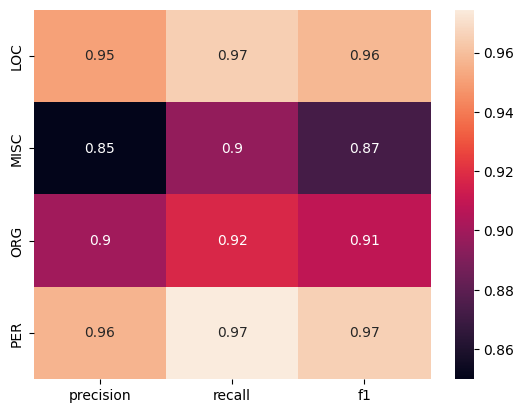

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(key_results[["precision", "recall", "f1"]], annot=True)
plt.show()

One could conclude that the relatively low performance achieved by **MISC** and **ORG** was due to the fact that they have relatively fewer samples compared to rest of the classes (see `key_results["number"]`)